In [172]:
% matplotlib inline
import numpy as np
import skimage.io as io
import os

## Convert Image into Bites and Reconstructure 

Remember a tfrecord file stores your data as binary strings, so first you need to learn how to convert your data into binaray strings

/Users/jianinglu1/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/jianinglu1/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


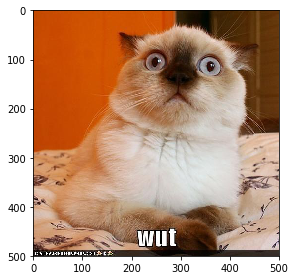

In [5]:
cat_img = io.imread("image/Confused-cat.jpg")
io.imshow(cat_img);

In [79]:
cat_img.dtype
type(cat_img)

dtype('uint8')

numpy.ndarray

In [23]:
cat_string = cat_img.tostring()

In [85]:
type(cat_string)

bytes

In [50]:
# using np.unit8 is because initial graph (cat_img) is np array with type as unit8
reconstructe_cat_1d = np.fromstring(cat_string,dtype=np.uint8)

/Users/jianinglu1/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


In [70]:
reconstructe_cat_img = np.reshape(reconstructe_cat_1d,cat_img.shape)

In [71]:
# np allclose Returns True if two arrays are element-wise equal within a tolerance.
np.allclose(cat_img,reconstructe_cat_img)

True

/Users/jianinglu1/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/jianinglu1/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


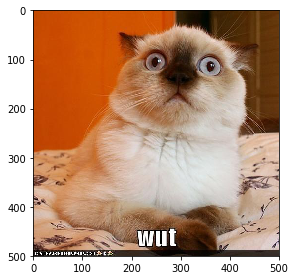

In [73]:
io.imshow(reconstructe_cat_img);

## Write Data into TFRecord Fileformat

In [81]:
import tensorflow as tf

/Users/jianinglu1/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jianinglu1/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Here, we used three types of data as examples: images, text and molecule structures

### 1) Using tf.train.Features to hold your features <bn>

In [446]:
### value are features from your data ###
### tf.train.Feature can used to wrap a list of data of a specifoc type

def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def _float64_feature(value):
    return tf.train.Feature(float64_list = tf.train.FlotList(value = [value]))

### use tf.train.Features to hold your features
def get_features(features, features_name):
    features_new = {name:None for name in features_name}
    for i in range(len(features)):
        f_type = type(features[i])
        if f_type == bytes:
            features_new[features_name[i]] = _bytes_feature(features[i])
        elif f_type == int:
            features_new[features_name[i]] = _int64_feature(features[i])
        elif f_type == float:
            features_new[features_name[i]] = _float64_feature(features[i])
    ### put feature with right data type into example
    features = tf.train.Features(feature = features_new)
    
    return features
            

In [451]:
### For cat image
image_data  = [io.imread("data/cat_image/" + file) for file in os.listdir("data/cat_image/")]
mask_data = [1,2,3,4]
for i in range(4):
    image_raw = image_data[i].tostring()
    mask_raw = mask_data[i]
    height = image_data[i].shape[0]
    width = image_data[i].shape[1]
    features = [image_raw,mask_raw,height,width]
    features_name = ["image_raw","mask_raw","height","width"]
    features = get_features(features,features_name)
    print(features.feature["height"])
    

int64_list {
  value: 200
}

int64_list {
  value: 1199
}

int64_list {
  value: 200
}

int64_list {
  value: 900
}



### 2) Write into TFRecord File

In [453]:
writer = tf.python_io.TFRecordWriter("cat_image.tfrecord")
for i in range(4):
    image_raw = image_data[i].tostring()
    mask_raw = mask_data[i]
    height = image_data[i].shape[0]
    width = image_data[i].shape[1]
    features = [image_raw,mask_raw,height,width]
    features_name = ["image_raw","mask_raw","height","width"]
    features = get_features(features,features_name)
    example = tf.train.Example(features = features)
    writer.write(example.SerializeToString())
writer.close()

### 3) Read TFRecord File

In [483]:
### simple way
record_iterator = tf.python_io.tf_record_iterator("cat_image.tfrecord")
for record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(record)
    print(example.features.feature["height"].int64_list.value[0])
    ### This is for data when writing tfrecord using bytes not int
    #print(np.fromstring(example.features.feature["height"].bytes_list.value[0], dtype=np.int64))
    #with tf.Session() as sess:
    #    sess.run(tf.decode_raw(example.features.feature["height"].bytes_list.value[0], tf.int64))

200
1199
200
900


(200, 200, 3)


/Users/jianinglu1/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/jianinglu1/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


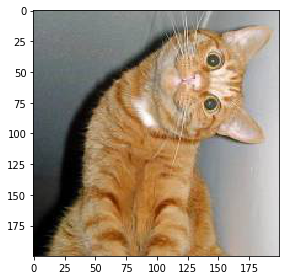

(1199, 1200, 3)


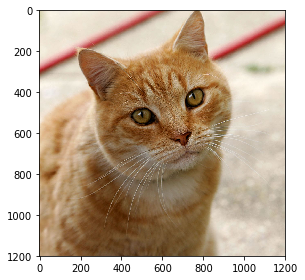

(200, 305, 3)


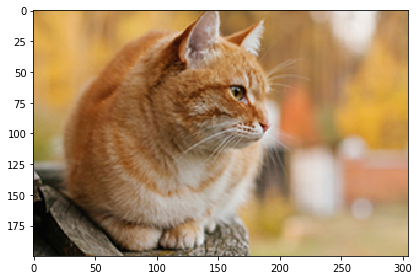

(900, 1440, 3)


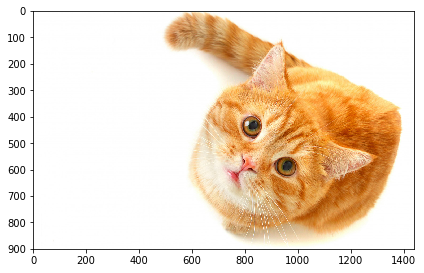

In [516]:
### using dataset method 
record = tf.data.TFRecordDataset("cat_image.tfrecord")
def _parser_function(record):
    features = {"image_raw":tf.FixedLenFeature((), tf.string),
                "mask_raw":tf.FixedLenFeature((), tf.int64),
                "height":tf.FixedLenFeature((), tf.int64),
                "width":tf.FixedLenFeature((), tf.int64)}
    parsed_features = tf.parse_single_example(record,features)
    features = {"image_raw":tf.decode_raw(parsed_features["image_raw"], tf.uint8),
                "mask_raw":parsed_features["mask_raw"],
                "height":parsed_features["height"],
                "width":parsed_features["width"]}

    return features

### Parse your features into tensor ###
record = record.map(_parser_function)
### Repeat the input indefinitely.
record = record.repeat()

iterator  = record.make_initializable_iterator()
features_new = iterator.get_next()

image_shape = tf.stack([features_new["height"], features_new["width"], 3])
image_new = tf.reshape(features_new["image_raw"], image_shape)


with tf.Session() as sess:
    sess.run(iterator.initializer)
    for i in range(4):
        #print(i)
        features,image = sess.run([features_new,image_new])
        #print(features)
        #image_shape = tf.stack([features["height"], features["width"], 3])
        #image = tf.reshape(features["image_raw"], image_shape)
        #image= sess.run(image)
        print(image.shape)
        io.imshow(image)
        io.show()

#features    

Notes: <br>
Tensorflow doesn't provide encoding and decoding thing for string as python, and these thing should be done using python after you read the tfrecord <br>
When read data, should use right type of for your features <br>
If features have been converted into bytes, remember convert it back using tf.decode_raw <br>


## Another Example: Molecule Structures and Properties Data

Here, we use QM9_MMFF dataset as example

In [901]:
### Download GDB-9 dataset from 'https://ndownloader.figshare.com/files/3195389'

In [554]:
import tarfile
import tempfile
### for units conversion ### 
from ase.units import Hartree, eV, Bohr, Ang

tmpdir = tempfile.mkdtemp('gdb9')
raw_path = os.path.join(tmpdir, 'gdb9_xyz')
tar = tarfile.open("data/dsgdb9nsd.xyz.tar.bz2")


In [ ]:
conversions = [1., 1., 1., 1., 1.,
                Hartree / eV, Hartree / eV, Hartree / eV,
                1., Hartree / eV,
                Hartree / eV, Hartree / eV, Hartree / eV,
                Hartree / eV, 1.]
element_conversions = {"H":1,"C":6,"O":8,"N":7,"F":9}

In [865]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = value))

def _float64_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

### use tf.train.Features to hold your features
def get_features(features, features_name):
    features_new = {"index":_int64_feature([features[0]]), 
                    "atomnum":_int64_feature([features[1]]),
                    "elements":_int64_feature(features[2]),
                    "coords":_float64_feature(features[3]),
                    "charge":_float64_feature(features[4]),
                    "properties":_float64_feature(features[5]),
                    "InChI":_bytes_feature([features[6]])}

    ### put feature with right data type into example
    #print(features_new)
    features = tf.train.Features(feature = features_new)
    
    return features
            

In [889]:
### use 10 structures as examples ###
writer = tf.python_io.TFRecordWriter("QM9_example.tfrecord")
tar_list = tar.getnames()[0:10]
for name in tar_list:
    tar.extract(name,path = raw_path)
    with open(os.path.join(raw_path,name)) as f:
        index = int(info.name.split("_")[1].split(".")[0])
        lines = f.readlines()
        atom_num = int(lines[0])
        elements = [element_conversions[line.split()[0]] for line in lines[2: atom_num + 2]]
        ### using ravel to flat numpy array ###
        positions = np.array([line.split()[1:4] for line in lines[2: atom_num + 2]]).astype(np.float32).ravel()
        charge = [float(line.split()[4:5][0]) for line in lines[2: atom_num + 2]]
        properties_init = lines[1].split()[2:]
        properties = []
        for p, c in zip(properties_init, conversions):
                properties.append(float(p) * c)
    
        InChI = lines[-1].split("=")[1].split()[0].encode('utf-8')
    
        #print(index,atom_num,elements,positions,charge,properties,InChI)
        
        features = [index, atom_num, elements, positions, charge, properties, InChI]
        features_new = get_features(features, features_name)
        #print(features_new)
        
        example = tf.train.Example(features = features_new)
        writer.write(example.SerializeToString())
writer.close()
        

One thing should be noted: <br>
If you convert all things into sting (first converting into numpy array and then converting into bytes using tostring), the feature lengths are same for all molecules(= one string). However, if didn't convert, should use tf.FixedLenSequenceFeature, which can consider features having different length for each instance. 

In [900]:
### check tfrecord ###
record = tf.data.TFRecordDataset("QM9_example.tfrecord")
def _parser_function(record):
    features = {"index":tf.FixedLenFeature([], tf.int64),
                "atomnum":tf.FixedLenFeature([], tf.int64),
                 "elements":tf.FixedLenSequenceFeature([], tf.int64,allow_missing = True),
                #"elements":tf.FixedLenFeature([], tf.string)}
                "coords":tf.FixedLenSequenceFeature([], tf.float32, allow_missing = True),
                 #"coords":tf.FixedLenFeature([], tf.float32)}
                "charge":tf.FixedLenSequenceFeature([], tf.float32, allow_missing = True),
                #"properties":tf.FixedLenFeature([], tf.float32)}
                "InChI":tf.FixedLenFeature([], tf.string)}
    
    parsed_features = tf.parse_single_example(record,features)
    features_new = {}
    for i in parsed_features.keys():
        if i == "coords":
            ### reshpae your coordinates to [None,3], here -1 infer to any number when columns=3 ###
            feat = tf.reshape(parsed_features[i],[-1,3])
        else:
            feat = parsed_features[i]
        ### This is usde when your features needed to be decoded ###
        #feat = tf.decode_raw(parsed_features[i],tf.int64)
        features_new[i] = feat
        
    print(features_new)

    return features_new

### Parse your features into tensor ###
record = record.map(_parser_function)
### Repeat the input indefinitely.
record = record.repeat()
### Padding to give same atom size for each molecule
record = record.padded_batch(batch_size = 10, padded_shapes={"index":[],"atomnum":[],"elements":[None],"coords":[None,3],"charge":[None],"InChI":[],}, padding_values=None)
### Different shape for your data (This is for list)
#record = record.padded_batch(batch_size = 10, padded_shapes=([],[],[None],[None,3],[None],[],), padding_values=None)

iterator  = record.make_initializable_iterator()
features_new = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer)
    features = sess.run([features_new])
    print(features)  


{'InChI': <tf.Tensor 'ParseSingleExample/ParseSingleExample:0' shape=() dtype=string>, 'atomnum': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=() dtype=int64>, 'charge': <tf.Tensor 'ParseSingleExample/ParseSingleExample:2' shape=(?,) dtype=float32>, 'coords': <tf.Tensor 'Reshape:0' shape=(?, 3) dtype=float32>, 'elements': <tf.Tensor 'ParseSingleExample/ParseSingleExample:4' shape=(?,) dtype=int64>, 'index': <tf.Tensor 'ParseSingleExample/ParseSingleExample:5' shape=() dtype=int64>}
[{'InChI': array([b'1S/CH4/h1H4', b'1S/H3N/h1H3', b'1S/H2O/h1H2',
       b'1S/C2H2/c1-2/h1-2H', b'1S/CHN/c1-2/h1H', b'1S/CH2O/c1-2/h1H2',
       b'1S/C2H6/c1-2/h1-2H3', b'1S/CH4O/c1-2/h2H,1H3',
       b'1S/C3H4/c1-3-2/h1H,2H3', b'1S/C2H3N/c1-2-3/h1H3'], dtype=object), 'atomnum': array([5, 4, 3, 4, 3, 4, 8, 6, 7, 6]), 'charge': array([[-0.535689,  0.133921,  0.133922,  0.133923,  0.133923,  0.      ,
         0.      ,  0.      ],
       [-0.707143,  0.235712,  0.235712,  0.23572 ,  0.      ,  0

 Thus, we can convert structures from tar file directly into tfrecord without decompressing !